In [86]:
# DATA2001 Assignment

from IPython.display import HTML
HTML('''
    <style> body {font-family: "Roboto Condensed Light", "Roboto Condensed";} h2 {padding: 10px 12px; background-color: #E64626; position: static; color: #ffffff; font-size: 40px;} .text_cell_render p { font-size: 15px; } .text_cell_render h1 { font-size: 30px; } h1 {padding: 10px 12px; background-color: #E64626; color: #ffffff; font-size: 40px;} .text_cell_render h3 { padding: 10px 12px; background-color: #0148A4; position: static; color: #ffffff; font-size: 20px;} h4:before{ 
    content: "@"; font-family:"Wingdings"; font-style:regular; margin-right: 4px;} .text_cell_render h4 {padding: 8px; font-family: "Roboto Condensed Light"; position: static; font-style: italic; background-color: #FFB800; color: #ffffff; font-size: 18px; text-align: center; border-radius: 5px;}input[type=submit] {background-color: #E64626; border: solid; border-color: #734036; color: white; padding: 8px 16px; text-decoration: none; margin: 4px 2px; cursor: pointer; border-radius: 20px;}</style>
''')

# Assignment

## Setup

First we import all of the modules that are going to be used, then define a 'query' and 'pgconnect' function for querying the database.

In [87]:
from sqlalchemy import create_engine, text, types
import psycopg2
import psycopg2.extras
import json
import os
import pandas as pd
import geoalchemy2
import geopandas as gpd
import requests
from shapely.geometry import mapping, point
import time
import matplotlib.pyplot as plt
import folium
from folium.features import GeoJsonTooltip, GeoJson, GeoJsonPopup  
import branca.colormap as cm
import plotly.express as px
import nbformat


credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        port       = db_conn_dict['port']
        try:
            db = create_engine(f'postgresql+psycopg2://{db_user}:{db_pw}@{host}:{port}/{default_db}', echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(text(sqlcmd), args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

In [88]:
db, conn = pgconnect(credentials)
conn.execute(text("set search_path to public"))

Connected successfully.


### Loading Data into Python from .csv, .txt and .shp

In [89]:
data_path = "data"

population_df = pd.read_csv(f"{data_path}/Population.csv")
businesses_df = pd.read_csv(f"{data_path}/Businesses.csv")
income_df = pd.read_csv(f"{data_path}/sa2_income.csv")
postcode_df = pd.read_csv(f"{data_path}/sa2_postcode.csv")
stops_df = pd.read_csv(f"{data_path}/Stops.txt")

sa2_gdf = gpd.read_file(f"{data_path}/SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp")
primary_catchments = gpd.read_file(f"{data_path}/catchments/catchments_primary.shp")
secondary_catchments = gpd.read_file(f"{data_path}/catchments/catchments_secondary.shp")

## Data cleaning before ingestion into database

### Cleaning population

Examining the contents of population through its .info(), we see it is a clean dataset, with all fields having a value and consisting of an appropriate datatype. All that needs to be done is standardisation of the column names as below.

In [90]:
print(population_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   sa2_code            373 non-null    int64 
 1   sa2_name            373 non-null    object
 2   0-4_people          373 non-null    int64 
 3   5-9_people          373 non-null    int64 
 4   10-14_people        373 non-null    int64 
 5   15-19_people        373 non-null    int64 
 6   20-24_people        373 non-null    int64 
 7   25-29_people        373 non-null    int64 
 8   30-34_people        373 non-null    int64 
 9   35-39_people        373 non-null    int64 
 10  40-44_people        373 non-null    int64 
 11  45-49_people        373 non-null    int64 
 12  50-54_people        373 non-null    int64 
 13  55-59_people        373 non-null    int64 
 14  60-64_people        373 non-null    int64 
 15  65-69_people        373 non-null    int64 
 16  70-74_people        373 no

In [91]:
cleaned_population_df = population_df.copy()

cleaned_population_df.columns = (
    cleaned_population_df.columns
    .str.lower()
    .str.replace('-', '_')
    .str.replace(' ', '_')
)


### Cleaning Businesses

The business dataset, summarised below, has all fields filled and is in an appropriate datatype. We renamed the columns to make it more readable

In [92]:
print(businesses_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12217 entries, 0 to 12216
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   industry_code           12217 non-null  object
 1   industry_name           12217 non-null  object
 2   sa2_code                12217 non-null  int64 
 3   sa2_name                12217 non-null  object
 4   0_to_50k_businesses     12217 non-null  int64 
 5   50k_to_200k_businesses  12217 non-null  int64 
 6   200k_to_2m_businesses   12217 non-null  int64 
 7   2m_to_5m_businesses     12217 non-null  int64 
 8   5m_to_10m_businesses    12217 non-null  int64 
 9   10m_or_more_businesses  12217 non-null  int64 
 10  total_businesses        12217 non-null  int64 
dtypes: int64(8), object(3)
memory usage: 1.0+ MB
None


In [93]:
cleaned_businesses_df = businesses_df.copy()
for col in cleaned_businesses_df.select_dtypes(include="object"):
    cleaned_businesses_df[col] = cleaned_businesses_df[col].str.strip()
cleaned_businesses_df.rename(columns={
    "0_to_50k_businesses": "b_0_50k",
    "50k_to_200k_businesses": "b_50k_200k",
    "200k_to_2m_businesses": "b_200k_2m",
    "2m_to_5m_businesses": "b_2m_5m",
    "5m_to_10m_businesses": "b_5m_10m",
    "10m_or_more_businesses": "b_10m_plus",
    "total_businesses": "total"
}, inplace=True)


### Cleaning Income

This dataset included 7 Sa2 regions for which there was no income figure given, we opted to fill these empty fields with the median for each. This is because it is likely that these values would be close to the central tendency.

In [94]:
print(income_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 642 entries, 0 to 641
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SA2_code          642 non-null    int64  
 1   SA2_name          642 non-null    object 
 2   income_earners    635 non-null    float64
 3   median_income     635 non-null    float64
 4   mean_income       635 non-null    float64
 5   gini_coefficient  624 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 30.2+ KB
None


In [95]:
cleaned_income_df = income_df.copy()

cleaned_income_df.rename(columns={
    "SA2_code": "sa2_code",
    "SA2_name": "sa2_name"
}, inplace=True)
cleaned_income_df['income_earners'].fillna(cleaned_income_df['income_earners'].median(), inplace=True)
cleaned_income_df['median_income'].fillna(cleaned_income_df['median_income'].median(), inplace=True)
cleaned_income_df['mean_income'].fillna(cleaned_income_df['mean_income'].median(), inplace=True)
cleaned_income_df['gini_coefficient'].fillna(cleaned_income_df['gini_coefficient'].median(), inplace=True)

/var/folders/7w/0bgjmph51g3fjv7yfs8y17xc0000gn/T/ipykernel_59257/4119000927.py:7: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/var/folders/7w/0bgjmph51g3fjv7yfs8y17xc0000gn/T/ipykernel_59257/4119000927.py:8: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing '

### Cleaning Postcode

As seen below, there is a discrepancy in the naming convention compared to our other datasets, so we opted to standardise it by renaming the columns to lowercase.

In [96]:
print(postcode_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624 entries, 0 to 623
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Postcode  624 non-null    int64 
 1   SA2_code  624 non-null    int64 
 2   SA2_name  624 non-null    object
dtypes: int64(2), object(1)
memory usage: 14.8+ KB
None


In [97]:
cleaned_postcode_df = postcode_df.copy()

postcode_df.rename(columns={
    "SA2_code": "sa2_code",
    "SA2_name": "sa2_name"
}, inplace=True)

### Cleaning Geodata

For the SA2_boundaries dataframe, we can see that the columns aren't named to convention, so we rename them. The sa2_code and sa4_code are also strings, which we typecast to integers as that is what has been used elsewhere, and allows for incrementation should another need to be added in future.

In [140]:
print(sa2_gdf.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 2472 entries, 0 to 2471
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   sa2_code  2472 non-null   int64   
 1   sa2_name  2472 non-null   object  
 2   sa4_code  2472 non-null   int64   
 3   geom      2454 non-null   geometry
dtypes: geometry(1), int64(2), object(1)
memory usage: 96.6+ KB
None


In [98]:
def clean_gdf(gdf):
    gdf = gdf.copy()
    gdf.columns = gdf.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('-', '_')

    for col in gdf.select_dtypes(include="object"):
        gdf[col] = gdf[col].str.strip()

    return gdf

cleaned_sa2_gdf = clean_gdf(sa2_gdf)
cleaned_primary_catchment= clean_gdf(primary_catchments)
cleaned_secondary_catchment = clean_gdf(secondary_catchments)

target_crs = "EPSG:4326"
cleaned_sa2_gdf = cleaned_sa2_gdf.to_crs(target_crs)
cleaned_primary_catchment = cleaned_primary_catchment.to_crs(target_crs)
cleaned_secondary_catchment = cleaned_secondary_catchment.to_crs(target_crs)

cleaned_sa2_gdf.rename(columns={
    "sa2_code21": "sa2_code",
    "sa2_name21": "sa2_name",
    "sa4_code21": "sa4_code",
    "sa4_name21": "sa4_name",
    "areasqkm21": "areasqkm"
}, inplace=True)

cleaned_sa2_gdf["sa2_code"] = pd.to_numeric(cleaned_sa2_gdf["sa2_code"], errors="coerce")
cleaned_sa2_gdf["sa4_code"] = pd.to_numeric(cleaned_sa2_gdf["sa4_code"], errors="coerce")

cleaned_sa2_gdf.dropna(subset=["sa2_code", "sa4_code"], inplace=True)

cleaned_sa2_gdf["sa2_code"] = cleaned_sa2_gdf["sa2_code"].astype(int)
cleaned_sa2_gdf["sa4_code"] = cleaned_sa2_gdf["sa4_code"].astype(int)

cleaned_school_catchment = pd.concat([cleaned_primary_catchment, cleaned_secondary_catchment], ignore_index=True)
cleaned_school_catchment.drop(columns=[
    "kindergart", "year1", "year2", "year3", "year4", "year5", "year6",
    "year7", "year8", "year9", "year10", "year11", "year12", "priority"
], inplace=True)
cleaned_school_catchment.rename(columns={
    "use_id": "school_id",
    "use_desc": "school_name",
    "geometry": "geom"  
}, inplace=True)


### Cleaning Stops

As seen below, there is no sa2 data in the stops df, as such we have to create a new column for the geom as an amalgamation of the longitude and latitude, then find which sa2 region that would overlap with. 
There are also columns that we don't need such as location type, latitude and longitude, platform code and parent station, which are dropped from the table.

In [139]:
print(stops_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114718 entries, 0 to 114717
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   stop_id              114718 non-null  object 
 1   stop_code            60719 non-null   float64
 2   stop_name            114718 non-null  object 
 3   stop_lat             114718 non-null  float64
 4   stop_lon             114718 non-null  float64
 5   location_type        53991 non-null   float64
 6   parent_station       60727 non-null   object 
 7   wheelchair_boarding  114718 non-null  int64  
 8   platform_code        871 non-null     object 
dtypes: float64(4), int64(1), object(4)
memory usage: 7.9+ MB
None


In [99]:

cleaned_stops_df = stops_df.copy()
conn.rollback()  

cleaned_stops_df.columns = cleaned_stops_df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('-', '_')

for col in cleaned_stops_df.select_dtypes(include='object'):
    cleaned_stops_df[col] = cleaned_stops_df[col].str.strip()

columns_to_drop = ['parent_station', 'stop_code', 'platform_code', 'location_type']
cleaned_stops_df = cleaned_stops_df.drop(columns=[col for col in columns_to_drop if col in cleaned_stops_df.columns])

cleaned_stops_df["geom"] = cleaned_stops_df.apply(
    lambda row: point.Point(row["stop_lon"], row["stop_lat"]), axis=1
)

stops_gdf = gpd.GeoDataFrame(cleaned_stops_df, geometry="geom", crs="EPSG:4326")
stops_gdf = stops_gdf.set_geometry("geom")

sa2_gdf = cleaned_sa2_gdf[["sa2_code", "sa2_name", "sa4_code", "geometry"]].copy()
sa2_gdf = sa2_gdf.rename(columns={"geometry": "geom"})
sa2_gdf = sa2_gdf.set_geometry("geom")

stops_gdf = stops_gdf.to_crs(sa2_gdf.crs)

stops_with_sa2 = gpd.sjoin(
    stops_gdf,
    sa2_gdf,
    how="left",
    predicate="within"
)

stops_with_sa2 = stops_with_sa2.drop(columns=["stop_lon", "stop_lat", "index_right"])


stops_with_sa2['sa2_code'] = pd.to_numeric(stops_with_sa2['sa2_code'], errors='coerce').astype('Int64')
stops_with_sa2['sa4_code'] = pd.to_numeric(stops_with_sa2['sa4_code'], errors='coerce').astype('Int64')

print(stops_with_sa2.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 114718 entries, 0 to 114717
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   stop_id              114718 non-null  object  
 1   stop_name            114718 non-null  object  
 2   wheelchair_boarding  114718 non-null  int64   
 3   geom                 114718 non-null  geometry
 4   sa2_code             114626 non-null  Int64   
 5   sa2_name             114626 non-null  object  
 6   sa4_code             114626 non-null  Int64   
dtypes: Int64(2), geometry(1), int64(1), object(3)
memory usage: 7.2+ MB
None


### Load in Geodata

### 1.2. Ingestion

We now need to ingest all of the collected data into the database as below, We define the table definitions as according to the schema diagram we created.

In [100]:
conn.execute(text("""
DROP TABLE IF EXISTS population CASCADE;
CREATE TABLE population (
    sa2_code BIGINT PRIMARY KEY,
    sa2_name TEXT,
    "0_4_people" INTEGER,
    "5_9_people" INTEGER,
    "10_14_people" INTEGER,
    "15_19_people" INTEGER,
    "20_24_people" INTEGER,
    "25_29_people" INTEGER,
    "30_34_people" INTEGER,
    "35_39_people" INTEGER,
    "40_44_people" INTEGER,
    "45_49_people" INTEGER,
    "50_54_people" INTEGER,
    "55_59_people" INTEGER,
    "60_64_people" INTEGER,
    "65_69_people" INTEGER,
    "70_74_people" INTEGER,
    "75_79_people" INTEGER,
    "80_84_people" INTEGER,
    "85_and_over_people" INTEGER,
    total_people INTEGER
);
                  
DROP TABLE IF EXISTS businesses CASCADE;
CREATE TABLE businesses (
    industry_code TEXT,
    industry_name TEXT,
    sa2_code BIGINT,
    sa2_name TEXT,
    b_0_50k INTEGER,
    b_50k_200k INTEGER,
    b_200k_2m INTEGER,
    b_2m_5m INTEGER,
    b_5m_10m INTEGER,
    b_10m_plus INTEGER,
    total INTEGER,
    PRIMARY KEY (sa2_code, industry_code)

);
                  
DROP TABLE IF EXISTS income CASCADE;
CREATE TABLE income (
    sa2_code BIGINT PRIMARY KEY,
    sa2_name TEXT,
    income_earners FLOAT,
    median_income FLOAT,
    mean_income FLOAT,
    gini_coefficient FLOAT
);
                  
DROP TABLE IF EXISTS postcode CASCADE;
CREATE TABLE postcode (
    postcode INTEGER,
    sa2_code BIGINT,
    sa2_name TEXT,
    PRIMARY KEY (postcode, sa2_code)
);
                  
DROP TABLE IF EXISTS stops CASCADE;
CREATE TABLE stops (
    stop_id TEXT,
    stop_name TEXT,
    sa2_code BIGINT,
    sa2_name TEXT,
    sa4_code INTEGER,
    wheelchair_boarding INTEGER,
    geom geometry(Point, 4326)
);
                  
DROP TABLE IF EXISTS sa2_boundaries CASCADE;
CREATE TABLE sa2_boundaries (
    sa2_code BIGINT PRIMARY KEY,
    sa2_name TEXT NOT NULL,
    sa4_code INTEGER,
    sa4_name TEXT,
    areasqkm DOUBLE PRECISION,
    geom geometry(MultiPolygon, 4326)
);
                  
DROP TABLE IF EXISTS school_catchments CASCADE;
CREATE TABLE school_catchments (
    school_id TEXT PRIMARY KEY,
    catch_type TEXT NOT NULL,
    school_name TEXT NOT NULL,
    add_date DATE,
    geom geometry(MultiPolygon, 4326) NOT NULL
);
                  
                  

CREATE INDEX idx_catchments_geom ON school_catchments USING GIST (geom);
"""))
cleaned_population_df.to_sql(
    "population",
    con=conn,
    if_exists='append',
    index=False,
    method='multi',          
    chunksize=1000           
)
cleaned_businesses_df.to_sql(
    "businesses",
    con=conn,
    if_exists='append',
    index=False,
    method='multi',         
    chunksize=1000          
)
cleaned_income_df.to_sql(
    "income",
    con=conn,
    if_exists='append',
    index=False,
    method='multi',         
    chunksize=1000          
)
cleaned_postcode_df.to_sql(
    "postcodes",
    con=conn,
    if_exists='append',
    index=False,
    method='multi',         
    chunksize=1000          
)

cleaned_school_catchment.set_geometry("geom", inplace=True)
stops_with_sa2 = gpd.GeoDataFrame(
    stops_with_sa2,
    geometry=stops_with_sa2["geom"],  
    crs="EPSG:4326"
)

stops_with_sa2.to_postgis("stops", conn, if_exists="replace", index=False)
cleaned_sa2_gdf.to_postgis("sa2_boundaries", conn, if_exists="replace", index=False)
cleaned_school_catchment.to_postgis("school_catchments", conn, if_exists="replace", index=False)
conn.commit()


## Task 2 - SA2 Point of Interests

### Pull all POIs in a given bounding box from the API

We now need to pull all of the points of interest (POIs), from the API that interest with a given geometry.

In [101]:
def shapely_to_esri_polygon(geom):
    """
    Converts a shapely Polygon or MultiPolygon to ESRI JSON polygon format.
    """
    if geom.geom_type == 'Polygon':
        return {
            "rings": [list(geom.exterior.coords)],
            "spatialReference": {"wkid": 4326}
        }
    elif geom.geom_type == 'MultiPolygon':
        rings = []
        for poly in geom.geoms:
            rings.append(list(poly.exterior.coords))
        return {
            "rings": rings,
            "spatialReference": {"wkid": 4326}
        }
    else:
        raise ValueError("Unsupported geometry type for ESRI Polygon")


def get_pois_in_polygon(geom):
    esri_geom = shapely_to_esri_polygon(geom)

    params = {
        "geometry": json.dumps(esri_geom),
        "geometryType": "esriGeometryPolygon",
        "inSR": "4326",
        "spatialRel": "esriSpatialRelIntersects",
        "outFields": "*",
        "returnGeometry": "true",
        "f": "json"
    }

    url = "https://maps.six.nsw.gov.au/arcgis/rest/services/public/NSW_POI/MapServer/0/query"

    try:
        response = requests.post(url, data=params)
        response.raise_for_status()
        return response.json()
    except requests.RequestException as e:
        print("Request failed:", e)
        return {}

### Loop Through each SA2 in SA4

We loop through all sa2s in a given sa4 area, appending the points of interest for that sa2 to a "pois_df" which is used to store the POIs, we wait 1 second between API calls so as to not overload it.

In [102]:
def get_sa2_geometries_by_sa4(sa4_code, conn):
    """
    Queries the PostGIS DB for SA2 geometries belonging to a given SA4 code.
    Returns a GeoDataFrame.
    """
    sql = """
        SELECT *
        FROM sa2_boundaries
        WHERE sa4_code = %s
    """
    try:
        gdf = gpd.read_postgis(sql, conn, params=(sa4_code,), geom_col="geometry")
        return gdf
    except Exception as e:
        print("Error loading SA2 geometries:", e)
        return gpd.GeoDataFrame()

In [103]:
def get_pois_for_sa2_bboxes(sa4_code, conn):

    sa2_in_sa4 = get_sa2_geometries_by_sa4(sa4_code, conn)
    print(f"Found {len(sa2_in_sa4)} SA2 regions in SA4 '{sa4_code}'")

    all_pois = []

    for idx, row in sa2_in_sa4.iterrows():
        sa2_code = row['sa2_code']
        sa2_name = row['sa2_name']
        bbox_geom = row.geometry.envelope

        print(f"\nQuerying POIs for SA2 code {sa2_code} ({sa2_name}) bounding box...")
        time.sleep(1)

        pois_result = get_pois_in_polygon(bbox_geom)
        features = pois_result.get("features", [])

        print(f"Found {len(features)} POIs in SA2 {sa2_code} bounding box.")

        for f in features:
            attr = f["attributes"]
            attr["sa2_code"] = sa2_code
            attr["sa2_name"] = sa2_name
            all_pois.append(attr)

    pois_df = pd.DataFrame(all_pois)
    print(f"\nTotal collected POIs: {len(pois_df)}")
    print(pois_df.head())
    return pois_df

In [104]:
chosen_sa4s = [117, 123, 125]
pois_df = pd.DataFrame()

for sa4_code in chosen_sa4s:
    partial_df = get_pois_for_sa2_bboxes(sa4_code, conn)
    pois_df = pd.concat([pois_df, partial_df], ignore_index=True)

Found 27 SA2 regions in SA4 '117'

Querying POIs for SA2 code 117011320 (Banksmeadow) bounding box...
Found 35 POIs in SA2 117011320 bounding box.

Querying POIs for SA2 code 117011321 (Botany) bounding box...
Found 45 POIs in SA2 117011321 bounding box.

Querying POIs for SA2 code 117011323 (Pagewood - Hillsdale - Daceyville) bounding box...
Found 110 POIs in SA2 117011323 bounding box.

Querying POIs for SA2 code 117011324 (Port Botany Industrial) bounding box...
Found 58 POIs in SA2 117011324 bounding box.

Querying POIs for SA2 code 117011325 (Sydney Airport) bounding box...
Found 117 POIs in SA2 117011325 bounding box.

Querying POIs for SA2 code 117011634 (Eastlakes) bounding box...
Found 57 POIs in SA2 117011634 bounding box.

Querying POIs for SA2 code 117011635 (Mascot) bounding box...
Found 68 POIs in SA2 117011635 bounding box.

Querying POIs for SA2 code 117021327 (Petersham - Stanmore) bounding box...
Found 109 POIs in SA2 117021327 bounding box.

Querying POIs for SA2 cod

### Create a new table for POIs

In [105]:
query(conn, "DROP TABLE IF EXISTS pois_from_bboxes;")
pois_df.to_sql(
    name='pois_from_bboxes',
    con=conn,
    if_exists='append',  
    index=False  
)
conn.commit()

Error encountered: 
This result object does not return rows. It has been closed automatically.


## Part 3 - Scores


While combing through the data we found that there were occurences of school catchments overlapping sa2 areas by as little as 1sqm which would count to the number of schools available for a given sa2. To fix this we count schools by their percentage coverage of a given SA2, ie. if a school catchment covers half of an sa2, it should only count as half a school.

To do this we create alookup table school_sa2_lookup, which contains the sa2_code and school ID as a composite PK, as well as the calculated percent coverage.

In [107]:
query(conn, """
DROP TABLE IF EXISTS school_sa2_lookup;

CREATE TABLE school_sa2_lookup AS
WITH transformed AS (
    SELECT
        sb.sa2_code,  -- updated column name here
        sb.sa4_code,
        sb.geometry AS sa2_geom,
        ST_Transform(sb.geometry, 3857) AS sa2_geom_3857,
        ST_Area(ST_Transform(sb.geometry, 3857)) AS sa2_area_3857,
        sc.school_id,
        ST_Transform(sc.geom, 3857) AS school_geom_3857
    FROM school_catchments sc
    JOIN sa2_boundaries sb
        ON ST_Intersects(sc.geom, sb.geometry)
    WHERE ST_Area(ST_Transform(sb.geometry, 3857)) > 0
)

SELECT
    sa2_code,
    school_id,
    LEAST(
        SUM(
            ST_Area(
                ST_Intersection(sa2_geom_3857, school_geom_3857)
            )
        ) / NULLIF(sa2_area_3857, 0),
        1.0
    ) AS sa2_overlap_ratio
FROM transformed
GROUP BY sa2_code, school_id, sa2_area_3857;
""")
conn.commit()


Error encountered: 
This result object does not return rows. It has been closed automatically.


### Calculating Scores

for calculation of scores, we can create a new view in the DB, calledscored_sa2_view, with all of the values we need such as z_scores for each category, aswell as the final score calculation. This view will assist going forward as it allows for easy access to any data that may be needed in plots.

In [131]:
conn.rollback()
score_df = query(conn, """
CREATE OR REPLACE VIEW scored_sa2_view AS
WITH school_overlap_agg AS (
    SELECT sa2_code, SUM(sa2_overlap_ratio) AS total_overlap
    FROM school_sa2_lookup
    GROUP BY sa2_code
),

base_data AS (
    SELECT
        sb.sa2_code,
        sb.sa2_name,
        sb.sa4_code,
        sb.sa4_name,

        pop.total_people AS total_population,

        -- Young population: 0–19 years old
        (COALESCE(pop."0_4_people", 0) + COALESCE(pop."5_9_people", 0) +
         COALESCE(pop."10_14_people", 0) + COALESCE(pop."15_19_people", 0)) AS young_population,

        -- Total businesses in key industries
        COALESCE(biz.business_total, 0) * 1000.0 / NULLIF(pop.total_people, 0) AS business_per_1000,

        -- Stops count
        COUNT(DISTINCT s.stop_id) AS stop_count,

        -- Raw catchment sum
        COALESCE(so.total_overlap, 0) AS school_catchment_weighted,

        -- Weighted schools per 1000 young people
        COALESCE(so.total_overlap, 0) * 1000.0 / 
        NULLIF(
            (COALESCE(pop."0_4_people", 0) + COALESCE(pop."5_9_people", 0) +
             COALESCE(pop."10_14_people", 0) + COALESCE(pop."15_19_people", 0)), 
        0) AS schools_per_1000_young,

        -- POIs count (filtered to relevant groups)
        COUNT(DISTINCT p.objectid) AS poi_count

    FROM sa2_boundaries sb
    LEFT JOIN population pop ON sb.sa2_code::BIGINT = pop.sa2_code

    LEFT JOIN (
        SELECT sa2_code, SUM(total) AS business_total
        FROM businesses
        WHERE industry_name IN ('Health Care and Social Assistance', 'Education and Training', 'Retail Trade')
        GROUP BY sa2_code
    ) biz ON sb.sa2_code::BIGINT = biz.sa2_code

    LEFT JOIN stops s ON sb.sa2_code = s.sa2_code
    LEFT JOIN school_overlap_agg so ON sb.sa2_code = so.sa2_code
    LEFT JOIN pois_from_bboxes p 
        ON sb.sa2_code = p.sa2_code
        AND p.poigroup IN (1, 3, 5)

    WHERE pop.total_people >= 100
    AND sb.sa4_code IN (117, 123, 125)

    GROUP BY sb.sa2_code, sb.sa2_name, sb.sa4_code, sb.sa4_name, pop.total_people,
             pop."0_4_people", pop."5_9_people", pop."10_14_people", pop."15_19_people",
             biz.business_total, so.total_overlap
),

z_scores AS (
    SELECT
        *,
        (business_per_1000 - AVG(business_per_1000) OVER()) / NULLIF(STDDEV_POP(business_per_1000) OVER(), 0) AS z_business,
        (stop_count - AVG(stop_count) OVER()) / NULLIF(STDDEV_POP(stop_count) OVER(), 0) AS z_stops,
        (schools_per_1000_young - AVG(schools_per_1000_young) OVER()) / NULLIF(STDDEV_POP(schools_per_1000_young) OVER(), 0) AS z_schools,
        (poi_count - AVG(poi_count) OVER()) / NULLIF(STDDEV_POP(poi_count) OVER(), 0) AS z_poi
    FROM base_data
),

scored AS (
    SELECT *,
        (z_business + z_stops + z_schools + z_poi) AS z_sum,
        1.0 / (1 + EXP(-(z_business + z_stops + z_schools + z_poi))) AS score
    FROM z_scores
)

SELECT *
FROM scored;
""")

Error encountered: 
This result object does not return rows. It has been closed automatically.


## Part 4 - Plots and results

In [119]:
conn.rollback()

sa4_codes = [117, 123, 125]

sql = """
SELECT
    sb.sa2_code,
    sb.sa2_name,
    sb.geometry,
    i.mean_income,
    COUNT(s.stop_id) AS stop_count
FROM sa2_boundaries sb
JOIN income i ON sb.sa2_code = i.sa2_code
LEFT JOIN stops s ON sb.sa2_code = s.sa2_code
WHERE sb.sa4_code = ANY(%s)
GROUP BY sb.sa2_code, sb.sa2_name, sb.geometry, i.mean_income
"""

sa2_income_stops_gdf = gpd.read_postgis(sql, conn, params=(sa4_codes,), geom_col="geometry")
sa2_income_stops_gdf = sa2_income_stops_gdf.to_crs(epsg=4326)

min_income = sa2_income_stops_gdf["mean_income"].min()
max_income = sa2_income_stops_gdf["mean_income"].max()
colormap = cm.linear.YlGnBu_09.scale(min_income, max_income)
colormap.caption = 'Mean Income'

sa2_income_stops_gdf["color"] = sa2_income_stops_gdf["mean_income"].apply(colormap)

centroid = sa2_income_stops_gdf.unary_union.centroid
m = folium.Map(location=[centroid.y, centroid.x], zoom_start=11, tiles="cartodbpositron")

tooltip = GeoJsonTooltip(
    fields=["sa2_name", "mean_income", "stop_count"],
    aliases=["SA2 Name:", "Mean Income:", "Stop Count:"],
    localize=True,
    sticky=True,
    labels=True,
    style=("background-color: white; color: #333; font-family: Arial; font-size: 12px; padding: 5px;")
)

geojson = folium.GeoJson(
    sa2_income_stops_gdf,
    name="SA2 Areas",
    style_function=lambda feature: {
        "fillColor": feature["properties"]["color"],
        "color": "black",
        "weight": 1,
        "fillOpacity": 0.7,
    },
    tooltip=tooltip,
    highlight_function=lambda x: {
        "weight": 2,
        "color": "black",
        "fillOpacity": 0.9,
    }
).add_to(m)

colormap.add_to(m)

disable_focus_js = """
<style>
    path:focus {
        outline: none;
    }
</style>
<script>
    document.addEventListener("DOMContentLoaded", function() {
        let paths = document.querySelectorAll("path");
        paths.forEach(function(path) {
            path.setAttribute("tabindex", "-1");
        });
    });
</script>
"""
m.get_root().html.add_child(folium.Element(disable_focus_js))

m

/var/folders/7w/0bgjmph51g3fjv7yfs8y17xc0000gn/T/ipykernel_59257/1119324851.py:29: DeprecationWarning:

The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.



## Results

### Sydney - City and Inner South

From the scores generated we can see there is a wide disparity in how well resourced the different sa2s in Sydney - City and Inner South are. with areas such as Miller's Point and Bankmeadows achieving a significantly higher score than other areas. Conversely, areas such as Zetland and botany were under resourced.

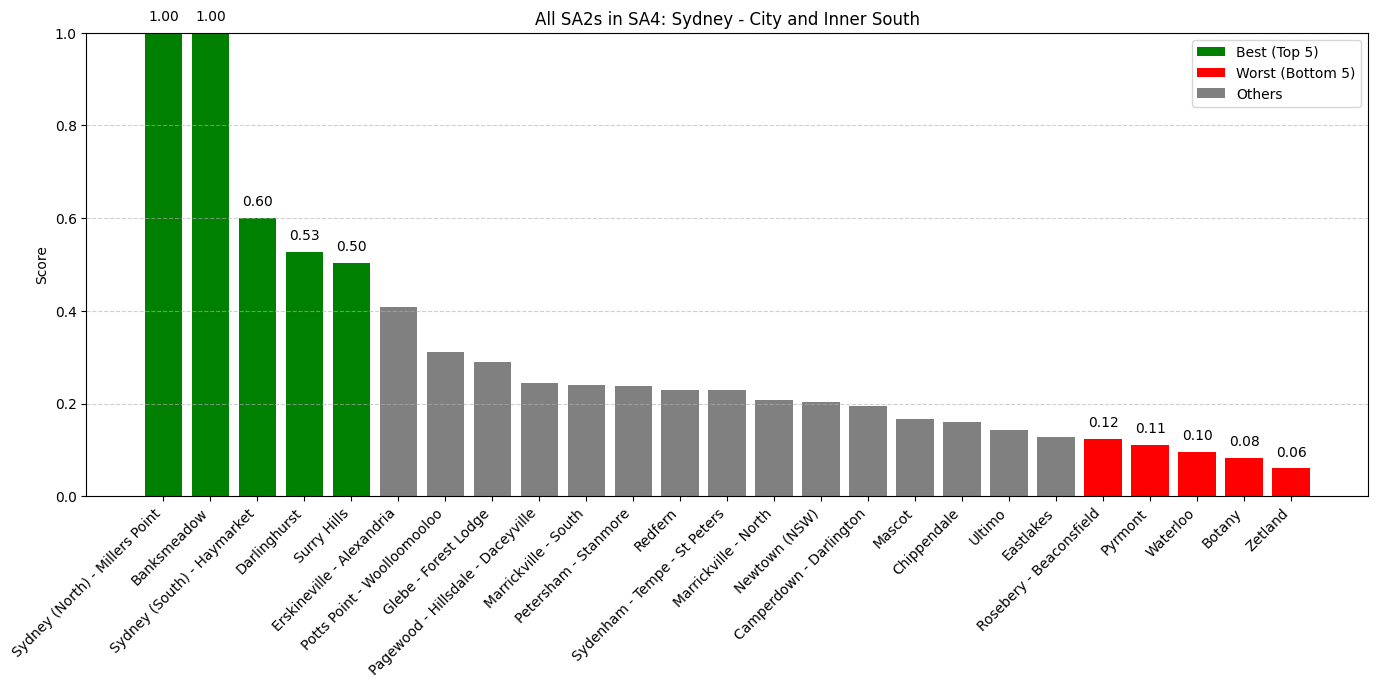

In [124]:
generate_score_chart(117)

### Top/Bottom SA2s

Looking further at the z-scores obtained in the calculation of the scores, it is apparent that those that performed the best were often skewed upwards by a particular area in which they were an extreme outlier. Miller's point is an example of this, as we can see that there is more than one business for every three people as it is an economic hub. Similarly, Banksmeakow's score is skewed upwards heavily by its small youth population. Despite having just 1.6 schools available when adjusted for coverage. Its schools score was brought up by the lack of population as our score formula accounts for schools available per 1000 students. The remaining areas at the top of the list were seemingly better resourced in all of the areas, but didn't have any where they were an extreme outlier. 

Contrastingly, when looking at the areas with the lowest scores, it seems they are average in below across the board, and didn't seem to suffer from the same outlier issue. It can thus be said that the score function we used is a better indicator of if an area is under-resourced than over.

In [134]:
query(conn, """
    SELECT * 
    FROM scored_sa2_view
    WHERE sa4_code = 117
    ORDER BY score DESC
    LIMIT 5""")

,sa2_code,sa2_name,sa4_code,sa4_name,total_population,young_population,business_per_1000,stop_count,school_catchment_weighted,schools_per_1000_young,poi_count,z_business,z_stops,z_schools,z_poi,z_sum,score
0,117031644,Sydney (North) - Millers Point,117,Sydney - City and Inner South,8199,634,344.798146,179,2.993715,4.721949,254,8.232493,0.571988,0.994220,2.787550,12.586251,0.999997
1,117011320,Banksmeadow,117,Sydney - City and Inner South,507,57,84.812623,18,1.648226,28.916251,21,1.597620,-1.417451,8.277466,-1.211959,7.245676,0.999287
2,117031645,Sydney (South) - Haymarket,117,Sydney - City and Inner South,20346,1521,52.344441,77,2.914060,1.915885,102,0.769027,-0.688402,0.149506,0.178428,0.408560,0.600743
3,117031329,Darlinghurst,117,Sydney - City and Inner South,10776,738,43.522643,56,3.000544,4.065778,75,0.543893,-0.947894,0.796692,-0.285034,0.107657,0.526888
4,117031336,Surry Hills,117,Sydney - City and Inner South,16053,1115,51.454557,60,3.005175,2.695224,79,0.746317,-0.898467,0.384112,-0.216373,0.015590,0.503897


In [135]:
query(conn, """
    SELECT * 
    FROM scored_sa2_view
    WHERE sa4_code = 117
    ORDER BY score ASC
    LIMIT 5""")

,sa2_code,sa2_name,sa4_code,sa4_name,total_population,young_population,business_per_1000,stop_count,school_catchment_weighted,schools_per_1000_young,poi_count,z_business,z_stops,z_schools,z_poi,z_sum,score
0,117031648,Zetland,117,Sydney - City and Inner South,12846,1333,16.191811,31,2.003862,1.503273,12,-0.153594,-1.256813,0.025297,-1.366446,-2.751556,0.059999
1,117011321,Botany,117,Sydney - City and Inner South,13035,3209,10.663598,68,1.900722,0.592310,30,-0.294675,-0.799613,-0.248931,-1.057471,-2.400690,0.083120
2,117031647,Waterloo,117,Sydney - City and Inner South,16639,1607,17.308732,61,1.573388,0.979084,27,-0.125090,-0.886110,-0.132500,-1.108967,-2.252667,0.095120
3,117031641,Pyrmont,117,Sydney - City and Inner South,12837,1636,25.083742,44,2.989388,1.827254,23,0.073330,-1.096175,0.122826,-1.177628,-2.077648,0.111288
4,117031643,Rosebery - Beaconsfield,117,Sydney - City and Inner South,12408,1776,20.551257,70,2.007552,1.130378,30,-0.042340,-0.774899,-0.086956,-1.057471,-1.961666,0.123287


In [121]:
def generate_score_chart(sa4_code):    
    subset = score_df[score_df['sa4_code'] == sa4_code].copy()
    sa4_name = subset['sa4_name'].iloc[0]  
    subset = subset.sort_values(by='score', ascending=False)

    top5_names = subset.nlargest(5, 'score')['sa2_name']
    worst5_names = subset.nsmallest(5, 'score')['sa2_name']

    def get_color(name):
        if name in top5_names.values:
            return 'green'
        elif name in worst5_names.values:
            return 'red'
        else:
            return 'gray'

    colors = subset['sa2_name'].apply(get_color)

    plt.figure(figsize=(14, 7))
    bars = plt.bar(subset['sa2_name'], subset['score'], color=colors)

    plt.title(f'All SA2s in SA4: {sa4_name}')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    for bar, name in zip(bars, subset['sa2_name']):
        if name in top5_names.values or name in worst5_names.values:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.2f}', ha='center', va='bottom')

    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='green', label='Best (Top 5)'),
        Patch(facecolor='red', label='Worst (Bottom 5)'),
        Patch(facecolor='gray', label='Others')
    ]
    plt.legend(handles=legend_elements)

    plt.tight_layout()
    plt.show()

In [128]:
def get_top_bottom_sa2_rows(score_df, top_n=5):
    sa4_groups = {}

    for sa4_code, group in score_df.groupby('sa4_code'):
        top5 = group.nlargest(top_n, 'score')
        bottom5 = group.nsmallest(top_n, 'score')

        combined = pd.concat([top5, bottom5]).copy()
        sa4_name = combined['sa4_name'].iloc[0]  
        sa4_groups[(sa4_code, sa4_name)] = combined.reset_index(drop=True)

    return sa4_groups

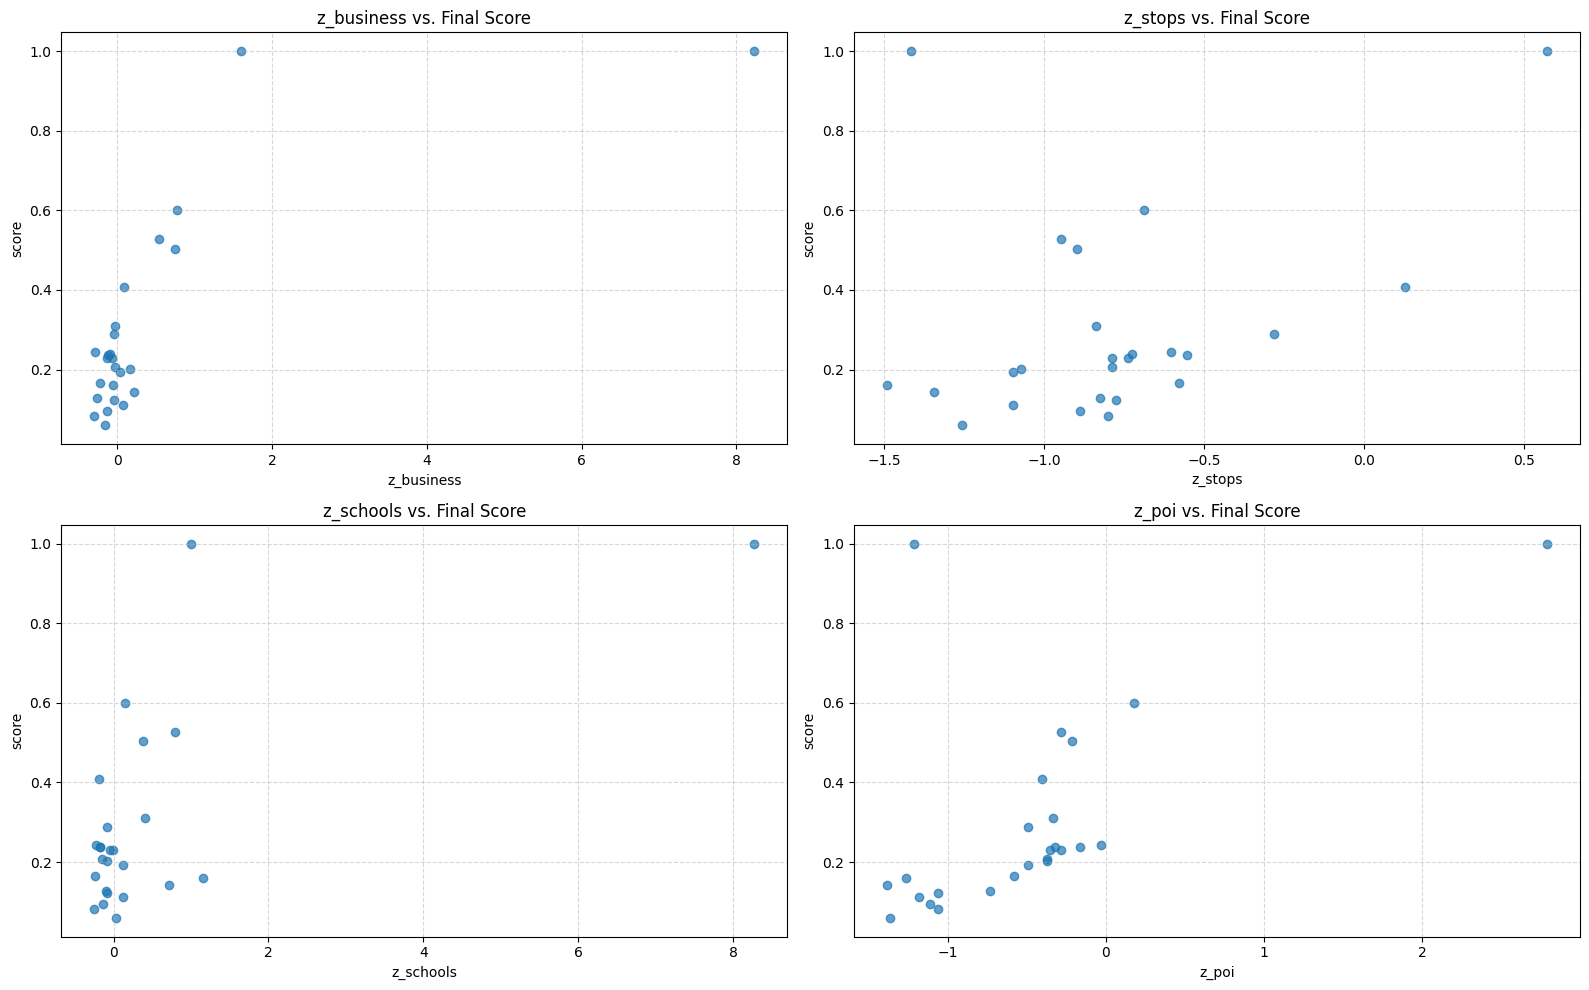

In [138]:
import matplotlib.pyplot as plt

# Query from the view for sa4_code = 117
query_str = """
SELECT *
FROM scored_sa2_view
WHERE sa4_code = 117
"""

subset = query(conn, query_str)  # Your function that returns a pandas DataFrame

# Define each z-score component to plot
z_components = ['z_business', 'z_stops', 'z_schools', 'z_poi']

# Set up the figure
plt.figure(figsize=(16, 10))

for i, z_col in enumerate(z_components, start=1):
    plt.subplot(2, 2, i)
    plt.scatter(subset[z_col], subset['score'], alpha=0.7)
    plt.xlabel(z_col)
    plt.ylabel('score')
    plt.title(f'{z_col} vs. Final Score')
    plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()